In [1]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np

from variance_partitioning import variance_partitioning
from himalaya.progress_bar import bar
from residual import residual_method
from simulation import generate_dataset

In [2]:
from himalaya.backend import set_backend

backend = set_backend("cupy", on_error="warn")

In [3]:
n_contributions = 5
X0_unique_contributions = np.linspace(10e-10, 1, n_contributions)
n_features_list = [1000, 1000]
n_targets = 1000
n_samples_train = 1000
n_samples_test = 1000
noise_level = 0.0

In [4]:
predicted_variance = []
predicted_residual = []

# create 2d data with unique contribution of X0 and X1 varying
for X0_unique_contribution in X0_unique_contributions:
    predicted_variance_X1 = []
    predicted_residual_X1 = []

    for i in bar(range(n_contributions), title=f"X0: {X0_unique_contribution} X1 unique contributions"):
        X1_contribution = (1 - X0_unique_contribution) * i / (n_contributions - 1)
        (Xs_train, Xs_test, Y_train, Y_test, n_targets_list) = generate_dataset(
            n_features_list=n_features_list, n_targets=n_targets,
            n_samples_train=n_samples_train, n_samples_test=n_samples_test,
            noise=noise_level, unique_contributions=[X0_unique_contribution, X1_contribution],
            random_distribution=np.random.randn, random_state=42)
        predicted_contribution_variance = variance_partitioning(Xs_train, Xs_test, Y_train, Y_test, use_refinement=True)
        predicted_variance_X1.append(predicted_contribution_variance)
        predicted_contribution_residual = residual_method(Xs_train, Xs_test, Y_train, Y_test, use_ols=False)
        predicted_residual_X1.append(predicted_contribution_residual)
    predicted_variance.append(predicted_variance_X1)
    predicted_residual.append(predicted_residual_X1)

[........................................] 100% | 29.57 sec | X0: 1e-09 X1 unique contributions | 
[........................................] 100% | 32.56 sec | X0: 0.25000000075 X1 unique contributions | 
[........................................] 100% | 31.16 sec | X0: 0.5000000005 X1 unique contributions | 
[........................................] 100% | 33.94 sec | X0: 0.75000000025 X1 unique contributions | 
[........................................] 100% | 28.12 sec | X0: 1.0 X1 unique contributions | 


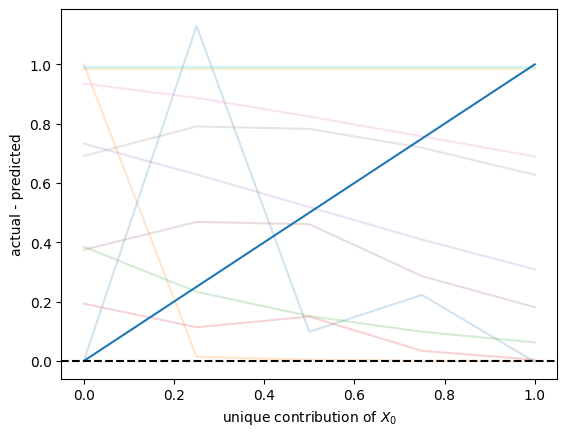

In [5]:
import matplotlib.pyplot as plt

for i, X0_unique_contribution in enumerate(X0_unique_contributions):
    plt.plot(X0_unique_contributions, predicted_variance[i], label=f"variance partitioning X0={X0_unique_contribution}",
             alpha=1 / n_contributions)
    plt.plot(X0_unique_contributions, predicted_residual[i], label=f"residual method X0={X0_unique_contribution}",
             alpha=1 / n_contributions)

plt.plot(X0_unique_contributions, X0_unique_contributions, label="true contribution")
plt.axhline(0, color="black", linestyle="--")
plt.xlabel(r"unique contribution of $X_0$")
plt.ylabel("actual - predicted")
plt.show()